In [351]:
import numpy as np

In [352]:
import pandas as pd

In [353]:
import matplotlib.pyplot as plt

In [354]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [355]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [356]:
data=data_frame.as_matrix()

In [357]:
image=data[0,1:].reshape((28,28))

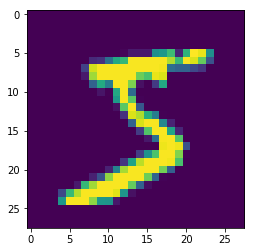

In [358]:
plt.imshow(image)
plt.show()

In [359]:
def show_image(data_matrix, index):
	image=data_matrix[index,1:].reshape((28,28))
	plt.imshow(image)
	plt.show()

In [383]:
data = data / 255 # TODO: poprawic, pierwsza kolumna (labele) nie powinna byc dzielona

In [384]:
data.shape

(60000, 785)

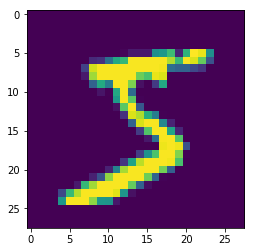

In [385]:
show_image(data, 0)

In [363]:
class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, activation_functions = None):
        self.train_data = train_data
        self.input_neurons_num = train_data.shape[1] # TODO: rozwazyc jeden wektor jako train_data
        self.neurons_num_per_layer = [self.input_neurons_num] + [hidden_layer_neurons_num] + [10]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: sigmoid_function(x)] * (self.layers_num - 2) + [lambda x: softmax_function(x)] 
        
        self.weight_list = [np.random.randn(self.current_layer_num, self.next_layer_num) \
                       for (self.current_layer_num, self.next_layer_num) in zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        
        self.bias_list = [np.random.randn(layer_num, 1) for layer_num in self.neurons_num_per_layer[1:]]
        
    def feed_forward(self, batch_size):
        for train_batch in self.create_train_batches(batch_size):
            layer_output = train_batch[:,1:]
            labels = self.one_hot_encoded(train_batch[:, 0])
            for activation_function, w, b in zip(self.activation_functions, weight_list, bias_list):
                layer_output = activation_function(np.sum(np.matmul(w, layer_output), b))
            return layer_output
    
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        print(train_labels.shape)
        res = np.zeros((self.neurons_num_per_layer[-1], train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        

In [364]:
net = Network(data[1:10, 1:], 2)

In [365]:
[matrix.shape for matrix in net.weight_list]

[(784, 2), (2, 10)]

In [366]:
net.input_neurons_num

784

In [367]:
net.weight_list

[array([[-1.31749762, -0.33302332],
        [ 1.30182819,  0.6666429 ],
        [ 0.8573799 , -0.94331996],
        ...,
        [-1.14011294, -1.23595511],
        [-1.49711898,  0.69865292],
        [-0.40997405, -0.23378951]]),
 array([[ 0.6050009 , -1.35175074, -0.36170662,  0.69120694,  0.80148513,
         -0.94622571, -0.8720735 , -0.44687664, -0.65134949,  0.08540484],
        [-0.9538406 ,  0.02430875,  2.06775945,  0.36680467,  1.33151369,
          0.68143138, -0.58133205,  0.68502098,  1.17282066,  2.97908718]])]

In [368]:
net.sigmoid_function(0)

0.5

In [369]:
[matrix.shape for matrix in net.create_train_batches(2)]

[(2, 784), (2, 784), (2, 784), (2, 784), (1, 784)]

In [370]:
np.argmax(net.softmax_function(np.array([1,2,3])))

2

In [371]:
net.softmax_function(np.array([1,2,3]))

array([0.09003057, 0.24472847, 0.66524096])

In [372]:
net.one_hot_encoded(np.array([1,2,3,4]))

(4,)


array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [373]:
net.feed_forward(2)

(2,)


NameError: name 'weight_list' is not defined